In [73]:
import lasagne
import numpy as np
import pickle
import skimage.transform
import scipy

import theano
import theano.tensor as T

from lasagne.utils import floatX

import matplotlib.pyplot as plt
%matplotlib inline

from skimage.io import imread, imsave
from skimage import filters

import train_ae

from time import time

In [2]:
from lasagne.layers import *
import sys
sys.path.append("../../modules/")
import helper as hp

In [3]:
import experiment
reload(experiment)

<module 'experiment' from 'experiment.pyc'>

In [3]:
train_set, valid_set, test_set = hp.load_mnist("../../data/mnist.pkl.gz")
Xt, yt = train_set

In [4]:
Xt9 = Xt[ yt == 9, ]

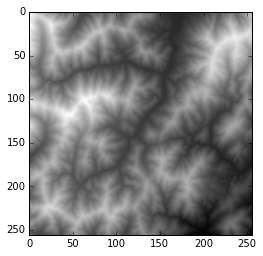

In [10]:
heightmap = np.load("train_data_minimal.npy")[5:6]
plt.imshow(heightmap[0][0], cmap="gray", vmin=0, vmax=1)

In [11]:
def gram_matrix(x):
    x = x.flatten(ndim=3)
    g = T.tensordot(x, x, axes=([2], [2]))
    return g

def style_loss(A, X, layer):
    a = A[layer]
    x = X[layer]
    
    A = gram_matrix(a)
    G = gram_matrix(x)
    
    N = a.shape[1]
    M = a.shape[2] * a.shape[3]
    
    loss = 1./(4 * N**2 * M**2) * ((G - A)**2).sum()
    return loss

def total_variation_loss(x):
    return (((x[:,:,:-1,:-1] - x[:,:,1:,:-1])**2 + (x[:,:,:-1,:-1] - x[:,:,:-1,1:])**2)**1.25).sum()

In [12]:
#net = build_model_2(size=128)
#net_raw = experiment.exp2()
import vgg_a_subset as config
net_raw = config.get_net({})

with open("output/vgg_a_subset.2.pkl") as f:
    set_all_param_values(net_raw, pickle.load(f))
layers = {}
for layer in get_all_layers(net_raw):
    if isinstance(layer, Conv2DLayer):
        layers[ str(layer) ] = layer
print layers

{'<lasagne.layers.conv.Conv2DLayer object at 0x11b498710>': <lasagne.layers.conv.Conv2DLayer object at 0x11b498710>, '<lasagne.layers.conv.Conv2DLayer object at 0x11b1a9e50>': <lasagne.layers.conv.Conv2DLayer object at 0x11b1a9e50>, '<lasagne.layers.conv.Conv2DLayer object at 0x11b498910>': <lasagne.layers.conv.Conv2DLayer object at 0x11b498910>, '<lasagne.layers.conv.Conv2DLayer object at 0x11b498950>': <lasagne.layers.conv.Conv2DLayer object at 0x11b498950>}


number of params: 959744
<lasagne.layers.input.InputLayer object at 0x11425b250>,(None, 1, 256, 256)
<lasagne.layers.noise.GaussianNoiseLayer object at 0x11b389c90>,(None, 1, 256, 256)
<lasagne.layers.conv.Conv2DLayer object at 0x11b1a9e50>,(None, 64, 254, 254)
<lasagne.layers.pool.MaxPool2DLayer object at 0x11b47d790>,(None, 64, 127, 127)
<lasagne.layers.conv.Conv2DLayer object at 0x11b498710>,(None, 128, 125, 125)
<lasagne.layers.pool.MaxPool2DLayer object at 0x11b4986d0>,(None, 128, 62, 62)
<lasagne.layers.conv.Conv2DLayer object at 0x11b498950>,(None, 256, 60, 60)
<lasagne.layers.conv.Conv2DLayer object at 0x11b498910>,(None, 256, 58, 58)
<lasagne.layers.special.InverseLayer object at 0x11b498d90>,(None, 256, 60, 60)
<lasagne.layers.special.InverseLayer object at 0x11b498d50>,(None, 128, 62, 62)
<lasagne.layers.special.InverseLayer object at 0x11b498dd0>,(None, 128, 125, 125)
<lasagne.layers.special.InverseLayer object at 0x11b498d10>,(None, 64, 127, 127)
<lasagne.layers.special.In

In [13]:
#photo = Xt9[0:1]
#photo = rock
photo = heightmap
print photo.dtype

float32


In [14]:
input_im_theano = T.tensor4()
outputs = lasagne.layers.get_output(layers.values(), input_im_theano)

art_features = {k: theano.shared(output.eval({input_im_theano: photo}))
                for k, output in zip(layers.keys(), outputs)}

In [15]:
art_features

{'<lasagne.layers.conv.Conv2DLayer object at 0x11b1a9e50>': <TensorType(float64, 4D)>,
 '<lasagne.layers.conv.Conv2DLayer object at 0x11b498710>': <TensorType(float64, 4D)>,
 '<lasagne.layers.conv.Conv2DLayer object at 0x11b498910>': <TensorType(float64, 4D)>,
 '<lasagne.layers.conv.Conv2DLayer object at 0x11b498950>': <TensorType(float64, 4D)>}

In [16]:
generated_image = theano.shared(floatX(np.random.uniform(0, 1, photo.shape)))
gen_features = lasagne.layers.get_output(layers.values(), generated_image)
gen_features = {k: v for k, v in zip(layers.keys(), gen_features)}
gen_features

{'<lasagne.layers.conv.Conv2DLayer object at 0x11b1a9e50>': Elemwise{tanh,no_inplace}.0,
 '<lasagne.layers.conv.Conv2DLayer object at 0x11b498710>': Elemwise{tanh,no_inplace}.0,
 '<lasagne.layers.conv.Conv2DLayer object at 0x11b498910>': Elemwise{tanh,no_inplace}.0,
 '<lasagne.layers.conv.Conv2DLayer object at 0x11b498950>': Elemwise{tanh,no_inplace}.0}

In [17]:
# Define loss function
losses = []

# style loss
for key in layers:
    losses.append(1e7*style_loss(art_features, gen_features, key))

# total variation penalty 0.1e-7
losses.append(0.001 * total_variation_loss(generated_image))

total_loss = sum(losses)

In [18]:
grad = T.grad(total_loss, generated_image)

In [19]:
# Theano functions to evaluate loss and gradient
f_loss = theano.function([], total_loss)
f_grad = theano.function([], grad)

# Helper functions to interface with scipy.optimize
def eval_loss(x0):
    x0 = floatX(x0.reshape(photo.shape))
    generated_image.set_value(x0)
    return f_loss().astype('float64')

def eval_grad(x0):
    x0 = floatX(x0.reshape(photo.shape))
    generated_image.set_value(x0)
    return np.array(f_grad()).flatten().astype('float64')

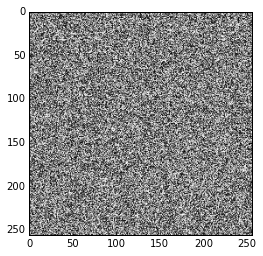

In [20]:
# Initialize with a noise image
generated_image.set_value(floatX(np.random.uniform(0, 1, photo.shape)))
#generated_image.set_value( floatX( 
#        filters.gaussian_filter(photo[0][0], 5).reshape( photo.shape )
#) )
plt.imshow(generated_image.get_value()[0][0], cmap="gray")

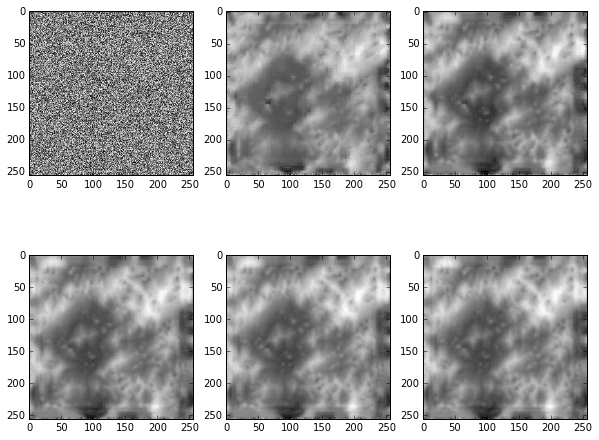

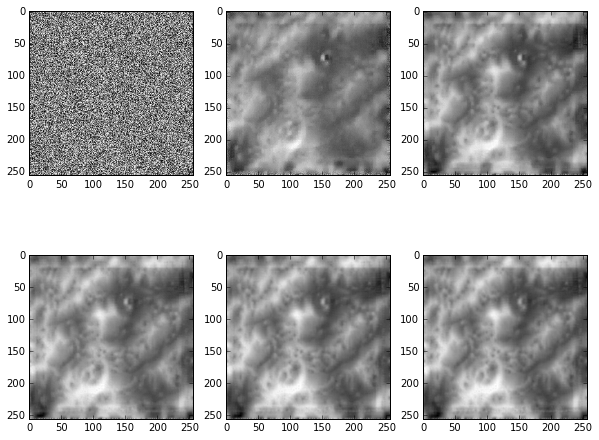

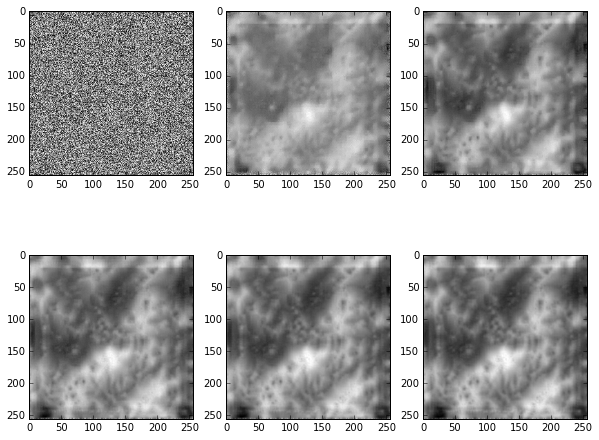

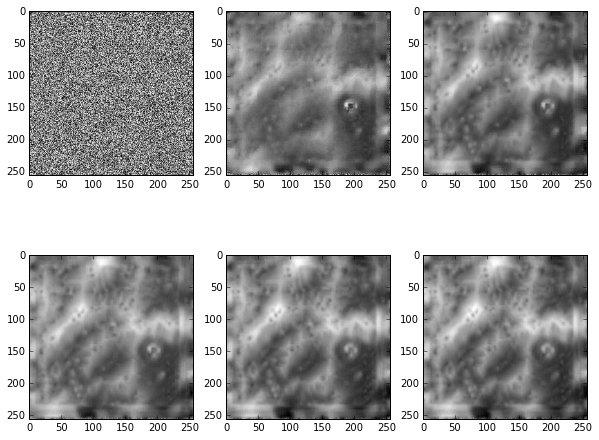

In [87]:
for iter_ in range(0, 4):
    
    t0 = time()
    
    generated_image.set_value(floatX(np.random.uniform(0, 1, photo.shape)))

    x0 = generated_image.get_value().astype('float64')
    xs = []
    xs.append(x0)
    for i in range(0, 6):
        scipy.optimize.fmin_l_bfgs_b(eval_loss, x0.flatten(), fprime=eval_grad, maxfun=40)
        x0 = generated_image.get_value().astype('float64')
        xs.append(x0)

    plt.figure(figsize=(10, 8))
    cc = 1
    nrow, ncol = 2, 3
    for i in range(0, nrow):
        for j in range(0, ncol):
            plt.subplot(nrow, ncol, cc)
            plt.imshow(xs[cc-1][0][0], cmap="gray")
            cc += 1
    plt.savefig("output_neat/%i_evolution.png" % t0)

    #plt.imshow(xs[-1][0][0], cmap="gray")
    #plt.savefig("output_neat/%i_final.png" % t0)
    
    img_norm = (xs[-1][0][0] - np.min(xs[-1][0][0])) / (np.max(xs[-1][0][0]) - np.min(xs[-1][0][0]) )
    
    imsave("output_neat/%i.png" % t0, arr=img_norm)

In [88]:
imsave("/tmp/seed_image.png", arr=photo)

//anaconda/lib/python2.7/site-packages/skimage/util/dtype.py:111: UserWarning: Possible precision loss when converting from float32 to uint16
  "%s to %s" % (dtypeobj_in, dtypeobj))


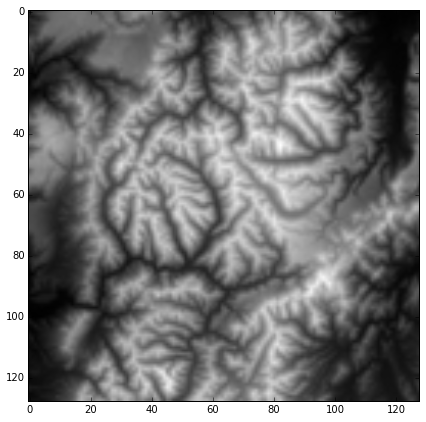

In [377]:
# original photo
plt.figure(figsize=(7,7))
plt.imshow(photo[0][0], cmap='gray')

----